#Solve

##Required components


In [ ]:
!apt-get --purge удалить cuda nvidia * libnvidia-*
!dpkg-l | grep cuda - / awk ' {print $2}' | xargs-n1 dpkg --purge
!apt-get remove cuda -*
!apt autoremove
!apt-get update

E: Command line option --purge is not understood in combination with the other options
/bin/bash: xargs-n1: command not found
/bin/bash: dpkg-l: command not found
grep: /: Is a directory
grep: awk: No such file or directory
grep:  {print $2}: No such file or directory
E: Command line option '*' [from -*] is not understood in combination with the other options.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get

In [ ]:
!wget https:/ /developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64 -O cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg-i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-9-2-local/7fa2af80.паб
!apt-get update
!apt-get install cuda-9.2

--2020-12-12 13:37:45--  ftp://https//
           => ‘.listing’
Resolving https (https)... failed: Name or service not known.
wget: unable to resolve host address ‘https’
/developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64: Scheme missing.
/bin/bash: dpkg-i: command not found
gpg: can't open '/var/cuda-repo-9-2-local/7fa2af80.паб': No such file or directory
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease

In [ ]:
!pip install git+git://github.com/andreinechaev/nvcc4jupyter.git

  Cloning git://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-6hahkfj3
  Running command git clone -q git://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-6hahkfj3
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4308 sha256=923f73cd105996c4e10fdfeef5570c79a79ca8b86f8becd9bdff196ef88af37d
  Stored in directory: /tmp/pip-ephem-wheel-cache-eub0mud2/wheels/10/c2/05/ca241da37bff77d60d31a9174f988109c61ba989e4d4650516
Successfully built NVCCPlugin


In [ ]:
%load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [ ]:
%reload_ext nvcc_plugin

directory /content/src already exists
Out bin /content/result.out


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


##Solve

In [ ]:
%%cu
#include <stdio.h>
#include <iostream>
#include <cuda.h>
#define N 10

__global__ void gpu(int *first, int *second, int *ans) 
{
  int x = blockIdx.x;
  int y = blockIdx.y;
  ans[N * y + x] = 0;
  for (int z = 0; z < N; z++)
  {
      ans[N * y + x] += first[N * y + z] * second[N * z + x];
  }    
}

void cpu(int first[N][N], int second[N][N], int ans[N][N])
{
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            ans[i][j] = 0;
            for (int z = 0; z < N; z++)
                ans[i][j] += first[i][z] * second[z][j];
        }
    }
}


int main() 
{
 
 int size = N*N*sizeof(int) ;
 int a[N][N]; //создание 3х матриц на хосте
 int b[N][N];
 int c[N][N]; 
 int *d_a, *d_b, *d_c; //копия матриц на девайсе

 for (int i = 0; i < N; i++) 
 {
    for (int j = 0; j < N; j++) 
    {
      a[i][j] = rand() %10 + 1;
      b[i][j] = rand() %10 + 1;
      c[i][j] = 0;
    }
 }

 cudaMalloc((void **)&d_a, size); 
 cudaMalloc((void **)&d_b, size);
 cudaMalloc((void **)&d_c, size);

 cudaEvent_t start, stop; 
 cudaEventCreate(&start);
 cudaEventCreate(&stop);  

 cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
 cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

 dim3 grid(N,N);
 
 cudaEventRecord(start);
 
 gpu <<<grid,1>>> (d_a,d_b,d_c);
 
 cudaEventRecord(stop);

 cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
 
 cudaEventSynchronize(stop);
 float milliseconds = 0;
 cudaEventElapsedTime(&milliseconds, start, stop);
 printf("GPU\n");
 printf("%f\n", milliseconds);

for (int i = 0; i < N; i++) 
 {
    for (int j = 0; j < N; j++) 
    {
      printf("%d\t",c[i][j]);
    }
   printf("\n");
 }
 printf("\n");
 cudaFree(d_a); 
 cudaFree(d_b); 
 cudaFree(d_c);
 
 cudaEvent_t start1, stop1;
 cudaEventCreate(&start1);
 cudaEventCreate(&stop1);
 cudaEventRecord(start1);
 
 cpu(a,b,c); 
 
 cudaEventRecord(stop1);
 cudaEventSynchronize(stop1);
 float milliseconds1 = 0;
 cudaEventElapsedTime(&milliseconds1, start1, stop1);
 
 printf( "CPU\n");
 printf("%f", milliseconds1);


 printf("\n"); 
 
 for (int i = 0; i < N; i++) 
 {
    for (int j = 0; j < N; j++) 
    {
      printf("%d\t",c[i][j]);
    }
   printf("\n");
 }

return 0;
}

GPU
0.025600
284	401	229	212	280	233	290	259	247	263	
288	486	248	245	305	314	283	262	304	350	
295	468	327	269	296	364	320	327	270	338	
291	448	262	242	263	321	278	282	257	288	
390	576	343	305	339	422	361	362	299	373	
340	514	319	274	321	350	334	319	279	335	
344	571	323	253	363	389	295	311	297	442	
349	449	269	224	298	321	330	268	258	339	
377	518	284	237	337	389	365	353	320	413	
370	624	347	308	396	423	353	375	355	454	

CPU
0.005856
284	401	229	212	280	233	290	259	247	263	
288	486	248	245	305	314	283	262	304	350	
295	468	327	269	296	364	320	327	270	338	
291	448	262	242	263	321	278	282	257	288	
390	576	343	305	339	422	361	362	299	373	
340	514	319	274	321	350	334	319	279	335	
344	571	323	253	363	389	295	311	297	442	
349	449	269	224	298	321	330	268	258	339	
377	518	284	237	337	389	365	353	320	413	
370	624	347	308	396	423	353	375	355	454	



Matrices equal

#Time it (dont look here)

More than N=800 colab do not calculate

##100

In [ ]:
%%cu
#include <stdio.h>
#include <iostream>
#include <cuda.h>
#define N 100

__global__ void gpu(int *first, int *second, int *ans) 
{
  int x = blockIdx.x;
  int y = blockIdx.y;
  ans[N * y + x] = 0;
  for (int z = 0; z < N; z++)
  {
      ans[N * y + x] += first[N * y + z] * second[N * z + x];
  }    
}

void cpu(int first[N][N], int second[N][N], int ans[N][N])
{
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            ans[i][j] = 0;
            for (int z = 0; z < N; z++)
                ans[i][j] += first[i][z] * second[z][j];
        }
    }
}


int main() 
{
 
 int size = N*N*sizeof(int) ;
 int a[N][N]; //создание 3х матриц на хосте
 int b[N][N];
 int c[N][N]; 
 int *d_a, *d_b, *d_c; //копия матриц на девайсе

 for (int i = 0; i < N; i++) 
 {
    for (int j = 0; j < N; j++) 
    {
      a[i][j] = rand() %10 + 1;
      b[i][j] = rand() %10 + 1;
      c[i][j] = 0;
    }
 }

 cudaMalloc((void **)&d_a, size); 
 cudaMalloc((void **)&d_b, size);
 cudaMalloc((void **)&d_c, size);

 cudaEvent_t start, stop; 
 cudaEventCreate(&start);
 cudaEventCreate(&stop);  

 cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
 cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

 dim3 grid(N,N);
 
 cudaEventRecord(start);
 
 gpu <<<grid,1>>> (d_a,d_b,d_c);
 
 cudaEventRecord(stop);

 cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
 
 cudaEventSynchronize(stop);
 float milliseconds = 0;
 cudaEventElapsedTime(&milliseconds, start, stop);
 printf("GPU\n");
 printf("%f\n", milliseconds);
 cudaFree(d_a); 
 cudaFree(d_b); 
 cudaFree(d_c);
 
 cudaEvent_t start1, stop1;
 cudaEventCreate(&start1);
 cudaEventCreate(&stop1);
 cudaEventRecord(start1);
 
 cpu(a,b,c); 
 
 cudaEventRecord(stop1);
 cudaEventSynchronize(stop1);
 float milliseconds1 = 0;
 cudaEventElapsedTime(&milliseconds1, start1, stop1);
 
 printf( "CPU\n");
 printf("%f", milliseconds1);
return 0;
}

GPU
0.347136
CPU
5.836416


##500

In [ ]:
%%cu
#include <stdio.h>
#include <iostream>
#include <cuda.h>
#define N 500

__global__ void gpu(int *first, int *second, int *ans) 
{
  int x = blockIdx.x;
  int y = blockIdx.y;
  ans[N * y + x] = 0;
  for (int z = 0; z < N; z++)
  {
      ans[N * y + x] += first[N * y + z] * second[N * z + x];
  }    
}

void cpu(int first[N][N], int second[N][N], int ans[N][N])
{
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            ans[i][j] = 0;
            for (int z = 0; z < N; z++)
                ans[i][j] += first[i][z] * second[z][j];
        }
    }
}


int main() 
{
 
 int size = N*N*sizeof(int) ;
 int a[N][N]; //создание 3х матриц на хосте
 int b[N][N];
 int c[N][N]; 
 int *d_a, *d_b, *d_c; //копия матриц на девайсе

 for (int i = 0; i < N; i++) 
 {
    for (int j = 0; j < N; j++) 
    {
      a[i][j] = rand() %10 + 1;
      b[i][j] = rand() %10 + 1;
      c[i][j] = 0;
    }
 }

 cudaMalloc((void **)&d_a, size); 
 cudaMalloc((void **)&d_b, size);
 cudaMalloc((void **)&d_c, size);

 cudaEvent_t start, stop; 
 cudaEventCreate(&start);
 cudaEventCreate(&stop);  

 cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
 cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

 dim3 grid(N,N);
 
 cudaEventRecord(start);
 
 gpu <<<grid,1>>> (d_a,d_b,d_c);
 
 cudaEventRecord(stop);

 cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
 
 cudaEventSynchronize(stop);
 float milliseconds = 0;
 cudaEventElapsedTime(&milliseconds, start, stop);
 printf("GPU\n");
 printf("%f\n", milliseconds);
 cudaFree(d_a); 
 cudaFree(d_b); 
 cudaFree(d_c);
 
 cudaEvent_t start1, stop1;
 cudaEventCreate(&start1);
 cudaEventCreate(&stop1);
 cudaEventRecord(start1);
 
 cpu(a,b,c); 
 
 cudaEventRecord(stop1);
 cudaEventSynchronize(stop1);
 float milliseconds1 = 0;
 cudaEventElapsedTime(&milliseconds1, start1, stop1);
 
 printf( "CPU\n");
 printf("%f", milliseconds1);
return 0;
}

GPU
66.781822
CPU
601.689270


##800

In [ ]:
%%cu
#include <stdio.h>
#include <iostream>
#include <cuda.h>
#define N 800

__global__ void gpu(int *first, int *second, int *ans) 
{
  int x = blockIdx.x;
  int y = blockIdx.y;
  ans[N * y + x] = 0;
  for (int z = 0; z < N; z++)
  {
      ans[N * y + x] += first[N * y + z] * second[N * z + x];
  }    
}

void cpu(int first[N][N], int second[N][N], int ans[N][N])
{
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            ans[i][j] = 0;
            for (int z = 0; z < N; z++)
                ans[i][j] += first[i][z] * second[z][j];
        }
    }
}


int main() 
{
 
 int size = N*N*sizeof(int) ;
 int a[N][N]; //создание 3х матриц на хосте
 int b[N][N];
 int c[N][N]; 
 int *d_a, *d_b, *d_c; //копия матриц на девайсе

 for (int i = 0; i < N; i++) 
 {
    for (int j = 0; j < N; j++) 
    {
      a[i][j] = rand() %10 + 1;
      b[i][j] = rand() %10 + 1;
      c[i][j] = 0;
    }
 }

 cudaMalloc((void **)&d_a, size); 
 cudaMalloc((void **)&d_b, size);
 cudaMalloc((void **)&d_c, size);

 cudaEvent_t start, stop; 
 cudaEventCreate(&start);
 cudaEventCreate(&stop);  

 cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
 cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

 dim3 grid(N,N);
 
 cudaEventRecord(start);
 
 gpu <<<grid,1>>> (d_a,d_b,d_c);
 
 cudaEventRecord(stop);

 cudaMemcpy(c, d_c, size, cudaMemcpyDeviceToHost);
 
 cudaEventSynchronize(stop);
 float milliseconds = 0;
 cudaEventElapsedTime(&milliseconds, start, stop);
 printf("GPU\n");
 printf("%f\n", milliseconds);
 cudaFree(d_a); 
 cudaFree(d_b); 
 cudaFree(d_c);
 
 cudaEvent_t start1, stop1;
 cudaEventCreate(&start1);
 cudaEventCreate(&stop1);
 cudaEventRecord(start1);
 
 cpu(a,b,c); 
 
 cudaEventRecord(stop1);
 cudaEventSynchronize(stop1);
 float milliseconds1 = 0;
 cudaEventElapsedTime(&milliseconds1, start1, stop1);
 
 printf( "CPU\n");
 printf("%f", milliseconds1);
return 0;
}

GPU
257.416107
CPU
3606.538574


#Graph

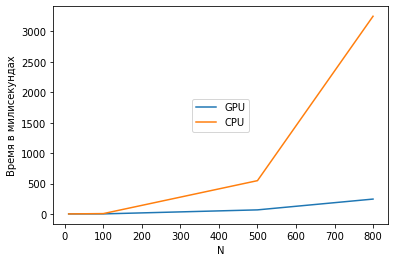

In [ ]:
import matplotlib.pyplot as plt

N = [10,100,500,800]
gpu = [0.020960, 0.339968, 66.390404, 243.964478]
cpu = [0.006144, 5.328384, 546.905701, 3250.069824]
plt.plot(N, gpu ,label = 'GPU')
plt.plot(N, cpu, label = 'CPU')
plt.xlabel("N")
plt.ylabel("Время в милисекундах")
plt.legend(loc = 'center')

plt.show()